In [1]:
import os
import numpy as np
import random
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.io import read_image
import torch.nn as nn



from functools import partial

import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm  # Import tqdm for progress bars

from mae_models import MaskedAutoencoderViT 

/home/alcindo/.pyenv/versions/meu_ambiente/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# Set device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


print("Using device: ", device)

Using device:  cuda


In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = (88,232)

In [4]:

class NumpyDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        # Get list of .npy file paths
        self.file_paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith(".npy")]
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        # Load the .npy file as a NumPy array
        image = np.load(file_path).astype(np.float32)  # Ensure it's float32 for PyTorch compatibility
        
        # If grayscale but missing channel dimension, add (C, H, W) format
        if image.ndim == 2:  
            image = np.expand_dims(image, axis=0)  # Convert (H, W) → (1, H, W)
        
        # Convert NumPy array to PyTorch tensor
        image = torch.from_numpy(image)
        # normalize to [0,1]
        image = image / torch.max(image)


        # Apply transformation if provided
        if self.transform:
            image = self.transform(image)

        return image

In [5]:
# Define the image transformations (resize to 224x224)
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE, antialias=True),
    # normalize to [0, 1]
    
])

# Define paths for data directories
data_dir = "/home/alcindo/projeto/masked-autoencoders-cows/processed_data"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")

# Create dataset instances
train_dataset = NumpyDataset(root_dir=train_dir, transform=transform)
val_dataset =  NumpyDataset(root_dir=val_dir, transform=transform)

# Create DataLoaders with multi-processing and pinned memory for efficiency
train_loader = DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size= BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)



In [6]:
# Initialize the MAE model with in_channels=1 for grayscale images and send it to device
model = MaskedAutoencoderViT(
        patch_size=8, embed_dim=64, depth=6, num_heads=8, in_chans=1, img_size= IMAGE_SIZE,
        decoder_embed_dim=32, decoder_depth=4, decoder_num_heads=4,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6))


model = model.to(device)
# Define the optimizer (AdamW)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)


In [7]:
def split_images(images, patch_size):
    """
    Splits images into patches, handling rectangular images.
    
    images: Input tensor [B, C, H, W]
    patch_size: Size of the patch (square)

    Returns:
    patches: Tensor of patches [B, C, num_patches_h * num_patches_w, patch_size, patch_size]
    """
    # Image dimensions
    B, C, H, W = images.shape
    
    # Number of patches in each dimension
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size
    
    # Create patches
    patches = images.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    patches = patches.contiguous().view(B, C, num_patches_h * num_patches_w, patch_size, patch_size)
    
    return patches, num_patches_h, num_patches_w

def apply_mask_to_patches(images, patches, masks, patch_size, num_patches_h, num_patches_w):
    """
    Applies a mask by replacing masked patches with a matrix of ones.

    images: Original tensor [B, C, H, W]
    patches: Tensor of patches [B, C, num_patches, patch_size, patch_size]
    masks: Mask tensor [B, num_patches] (0 to keep, 1 to mask)
    patch_size: Size of the patches
    num_patches_h, num_patches_w: Number of patches in height and width
    """
    B, C, num_patches, H, W = patches.shape  # Example: [128, 1, 196, 16, 16]
    masked_patches = patches.clone()
    ones_patch = torch.ones((C, patch_size, patch_size), device=patches.device)

    # Apply mask
    for b in range(masks.shape[0]):  # For each image in the batch
        for i in range(masks.shape[1]):  # For each patch
            if masks[b, i] == 1:
                masked_patches[b, :, i, :, :] = ones_patch  # Replace with ones

    # Reconstruct the masked images
    masked_images = masked_patches.view(B, C, num_patches_h, num_patches_w, patch_size, patch_size)
    masked_images = masked_images.permute(0, 1, 2, 4, 3, 5).contiguous().view(B, C, images.shape[-2], images.shape[-1])

    return masked_images


def visualize_image(original, masked_image, recon_images):
    """
    Plots original, masked, and reconstructed images.
    """

    index = random.randint(0, original.shape[0]-1)

    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    # Original image
    axes[0].imshow(original[index, 0].cpu().detach().numpy(), cmap="gray")
    axes[0].set_title("Original")
    axes[0].axis("off")

    # Masked image
    axes[1].imshow(masked_image[index, 0].cpu().detach().numpy(), cmap="gray")
    axes[1].set_title("Masked")
    axes[1].axis("off")

    # Reconstructed image
    axes[2].imshow(recon_images[index, 0].cpu().detach().numpy(), cmap="gray")
    axes[2].set_title("Reconstructed")
    axes[2].axis("off")

    plt.show()

Epoch [1/100] Train Loss: 0.65352330


Epoch [1/100] Validation Loss: 0.46439815


Epoch [2/100] Train Loss: 0.37901100


Epoch [2/100] Validation Loss: 0.31176618


Epoch [3/100] Train Loss: 0.27429238


Epoch [3/100] Validation Loss: 0.24221066


Epoch [4/100] Train Loss: 0.21948848


Epoch [4/100] Validation Loss: 0.19939575


Epoch [5/100] Train Loss: 0.18418881


Epoch [5/100] Validation Loss: 0.17074508


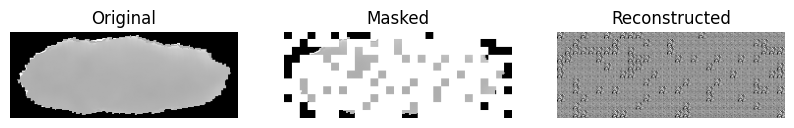

Epoch [6/100] Train Loss: 0.15981665


Epoch [6/100] Validation Loss: 0.15048543


Epoch [7/100] Train Loss: 0.14269496


Epoch [7/100] Validation Loss: 0.13615495


Epoch [8/100] Train Loss: 0.13077577


Epoch [8/100] Validation Loss: 0.12611896


Epoch [9/100] Train Loss: 0.12245827


Epoch [9/100] Validation Loss: 0.11952625


Epoch [10/100] Train Loss: 0.11677781


Epoch [10/100] Validation Loss: 0.11463402


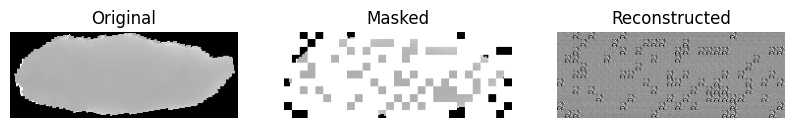

Epoch [11/100] Train Loss: 0.11277945


Epoch [11/100] Validation Loss: 0.11098226


Epoch [12/100] Train Loss: 0.10961687


Epoch [12/100] Validation Loss: 0.10835967


Epoch [13/100] Train Loss: 0.10702808


Epoch [13/100] Validation Loss: 0.10607227


Epoch [14/100] Train Loss: 0.10471430


Epoch [14/100] Validation Loss: 0.10244484


Epoch [15/100] Train Loss: 0.10184724


Epoch [15/100] Validation Loss: 0.10007739


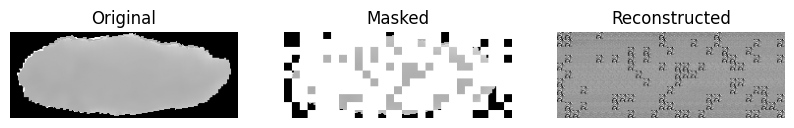

Epoch [16/100] Train Loss: 0.09880456


Epoch [16/100] Validation Loss: 0.09758877


Epoch [17/100] Train Loss: 0.09521654


Epoch [17/100] Validation Loss: 0.09325990


Epoch [18/100] Train Loss: 0.09158984


Epoch [18/100] Validation Loss: 0.08960046


Epoch [19/100] Train Loss: 0.08801259


Epoch [19/100] Validation Loss: 0.08713730


Epoch [20/100] Train Loss: 0.08502090


Epoch [20/100] Validation Loss: 0.08386774


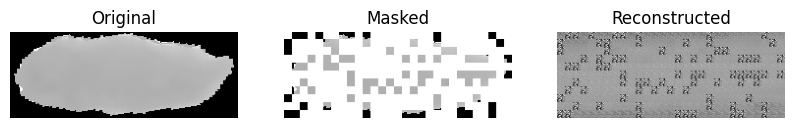

Epoch [21/100] Train Loss: 0.08208608


Epoch [21/100] Validation Loss: 0.08127017


Epoch [22/100] Train Loss: 0.07971349


Epoch [22/100] Validation Loss: 0.07757601


Epoch [23/100] Train Loss: 0.07709182


Epoch [23/100] Validation Loss: 0.07481904


Epoch [24/100] Train Loss: 0.07449412


Epoch [24/100] Validation Loss: 0.07403185


Epoch [25/100] Train Loss: 0.07210110


Epoch [25/100] Validation Loss: 0.07211146


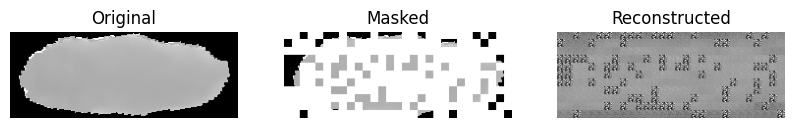

Epoch [26/100] Train Loss: 0.06987519


Epoch [26/100] Validation Loss: 0.07024863


Epoch [27/100] Train Loss: 0.06726014


Epoch [27/100] Validation Loss: 0.06754583


Epoch [28/100] Train Loss: 0.06496051


Epoch [28/100] Validation Loss: 0.06304012


Epoch [29/100] Train Loss: 0.06211512


Epoch [29/100] Validation Loss: 0.06198821


Epoch [30/100] Train Loss: 0.05939161


Epoch [30/100] Validation Loss: 0.05786254


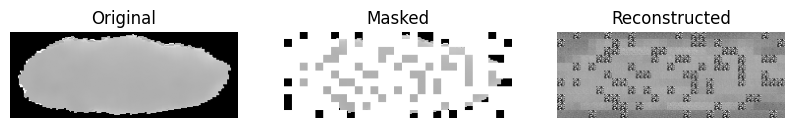

Epoch [31/100] Train Loss: 0.05541732


Epoch [31/100] Validation Loss: 0.05269448


Epoch [32/100] Train Loss: 0.05059583


Epoch [32/100] Validation Loss: 0.04683390


Epoch [33/100] Train Loss: 0.04440053


Epoch [33/100] Validation Loss: 0.04264962


Epoch [34/100] Train Loss: 0.04006142


Epoch [34/100] Validation Loss: 0.03738493


Epoch [35/100] Train Loss: 0.03682294


Epoch [35/100] Validation Loss: 0.03504578


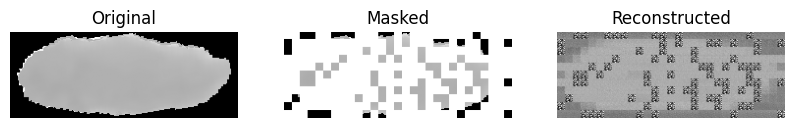

Epoch [36/100] Train Loss: 0.03434722


Epoch [36/100] Validation Loss: 0.03335172


Epoch [37/100] Train Loss: 0.03273189


Epoch [37/100] Validation Loss: 0.03211882


Epoch [38/100] Train Loss: 0.03154844


Epoch [38/100] Validation Loss: 0.03096259


Epoch [39/100] Train Loss: 0.03075838


Epoch [39/100] Validation Loss: 0.03073327


Epoch [40/100] Train Loss: 0.02986512


Epoch [40/100] Validation Loss: 0.03022521


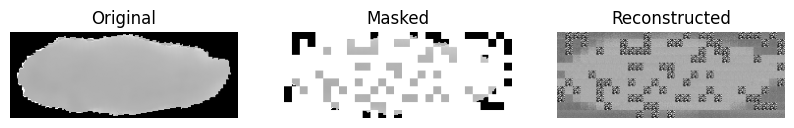

Epoch [41/100] Train Loss: 0.02946852


Epoch [41/100] Validation Loss: 0.02931908


Epoch [42/100] Train Loss: 0.02891953


Epoch [42/100] Validation Loss: 0.02828514


Epoch [43/100] Train Loss: 0.02832137


Epoch [43/100] Validation Loss: 0.02808640


Epoch [44/100] Train Loss: 0.02776609


Epoch [44/100] Validation Loss: 0.02737302


Epoch [45/100] Train Loss: 0.02718762


Epoch [45/100] Validation Loss: 0.02666867


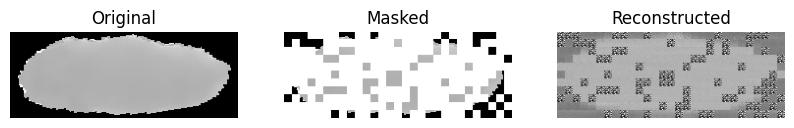

Epoch [46/100] Train Loss: 0.02678340


Epoch [46/100] Validation Loss: 0.02558404


Epoch [47/100] Train Loss: 0.02647018


Epoch [47/100] Validation Loss: 0.02538350


Epoch [48/100] Train Loss: 0.02573818


Epoch [48/100] Validation Loss: 0.02556728


Epoch [49/100] Train Loss: 0.02542900


Epoch [49/100] Validation Loss: 0.02539720


Epoch [50/100] Train Loss: 0.02493724


Epoch [50/100] Validation Loss: 0.02389426


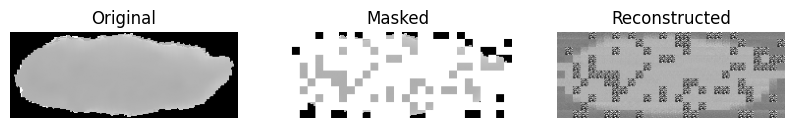

Epoch [51/100] Train Loss: 0.02480850


Epoch [51/100] Validation Loss: 0.02402235


Epoch [52/100] Train Loss: 0.02428207


Epoch [52/100] Validation Loss: 0.02437046


Epoch [53/100] Train Loss: 0.02405855


Epoch [53/100] Validation Loss: 0.02391983


Epoch [54/100] Train Loss: 0.02387459


Epoch [54/100] Validation Loss: 0.02315424


Epoch [55/100] Train Loss: 0.02351370


Epoch [55/100] Validation Loss: 0.02304357


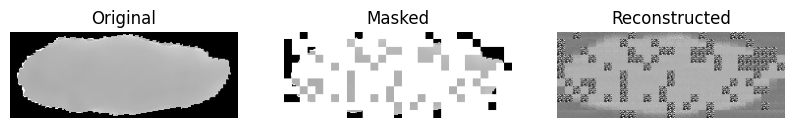

Epoch [56/100] Train Loss: 0.02210945


Epoch [56/100] Validation Loss: 0.02064440


Epoch [57/100] Train Loss: 0.02027577


Epoch [57/100] Validation Loss: 0.01916445


Epoch [58/100] Train Loss: 0.01961979


Epoch [58/100] Validation Loss: 0.01817881


Epoch [59/100] Train Loss: 0.01908834


Epoch [59/100] Validation Loss: 0.01932825


Epoch [60/100] Train Loss: 0.01913838


Epoch [60/100] Validation Loss: 0.01818381


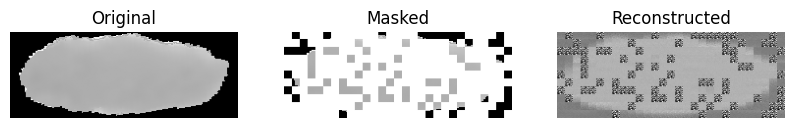

Epoch [61/100] Train Loss: 0.01854942


Epoch [61/100] Validation Loss: 0.01828992


Epoch [62/100] Train Loss: 0.01826781


Epoch [62/100] Validation Loss: 0.01766061


Epoch [63/100] Train Loss: 0.01841292


Epoch [63/100] Validation Loss: 0.01808589


Epoch [64/100] Train Loss: 0.01801209


Epoch [64/100] Validation Loss: 0.01740770


Epoch [65/100] Train Loss: 0.01781197


Epoch [65/100] Validation Loss: 0.01788997


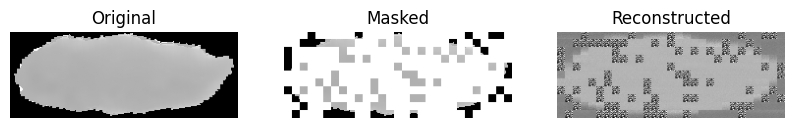

Epoch [66/100] Train Loss: 0.01778842


Epoch [66/100] Validation Loss: 0.01738751


Epoch [67/100] Train Loss: 0.01774085


Epoch [67/100] Validation Loss: 0.01691964


Epoch [68/100] Train Loss: 0.01750389


Epoch [68/100] Validation Loss: 0.01721177


Epoch [69/100] Train Loss: 0.01746271


Epoch [69/100] Validation Loss: 0.01727529


Epoch [70/100] Train Loss: 0.01726266


Epoch [70/100] Validation Loss: 0.01728318


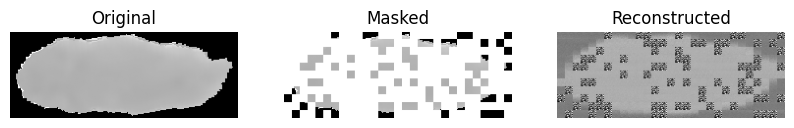

Epoch [71/100] Train Loss: 0.01732820


Epoch [71/100] Validation Loss: 0.01699443


Epoch [72/100] Train Loss: 0.01707578


Epoch [72/100] Validation Loss: 0.01651287


Epoch [73/100] Train Loss: 0.01703819


Epoch [73/100] Validation Loss: 0.01717638


Epoch [74/100] Train Loss: 0.01730385


Epoch [74/100] Validation Loss: 0.01664805


Epoch [75/100] Train Loss: 0.01691023


Epoch [75/100] Validation Loss: 0.01677125


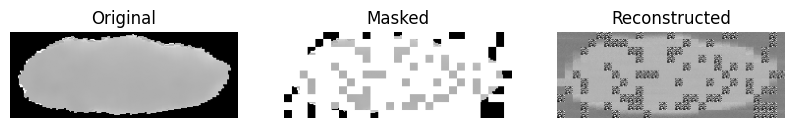

Epoch [76/100] Train Loss: 0.01686630


Epoch [76/100] Validation Loss: 0.01612266


Epoch [77/100] Train Loss: 0.01680571


Epoch [77/100] Validation Loss: 0.01630986


Epoch [78/100] Train Loss: 0.01700440


Epoch [78/100] Validation Loss: 0.01636586


Epoch [79/100] Train Loss: 0.01677525


Epoch [79/100] Validation Loss: 0.01656527


Epoch [80/100] Train Loss: 0.01664899


Epoch [80/100] Validation Loss: 0.01628697


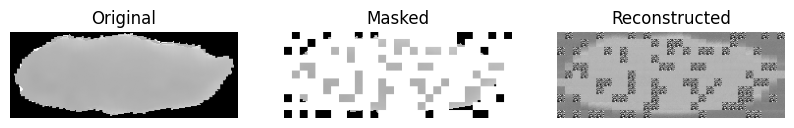

Epoch [81/100] Train Loss: 0.01660340


Epoch [81/100] Validation Loss: 0.01637195


Epoch [82/100] Train Loss: 0.01657938


Epoch [82/100] Validation Loss: 0.01638420


Epoch [83/100] Train Loss: 0.01652756


Epoch [83/100] Validation Loss: 0.01722641


Epoch [84/100] Train Loss: 0.01653847


Epoch [84/100] Validation Loss: 0.01631222


Epoch [85/100] Train Loss: 0.01635180


Epoch [85/100] Validation Loss: 0.01594372


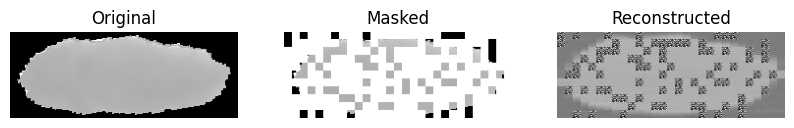

Epoch [86/100] Train Loss: 0.01628591


Epoch [86/100] Validation Loss: 0.01628885


Epoch [87/100] Train Loss: 0.01626998


Epoch [87/100] Validation Loss: 0.01621403


Epoch [88/100] Train Loss: 0.01615570


Epoch [88/100] Validation Loss: 0.01629514


Epoch [89/100] Train Loss: 0.01607450


Epoch [89/100] Validation Loss: 0.01550119


Epoch [90/100] Train Loss: 0.01598994


Epoch [90/100] Validation Loss: 0.01577643


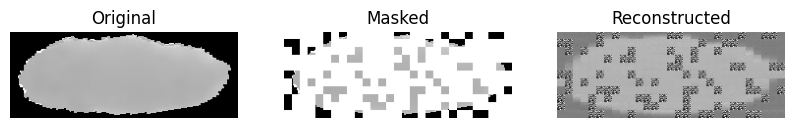

Epoch [91/100] Train Loss: 0.01590581


Epoch [91/100] Validation Loss: 0.01613947


Epoch [92/100] Train Loss: 0.01594654


Epoch [92/100] Validation Loss: 0.01544873


Epoch [93/100] Train Loss: 0.01585797


Epoch [93/100] Validation Loss: 0.01523101


Epoch [94/100] Train Loss: 0.01575079


Epoch [94/100] Validation Loss: 0.01524011


Epoch [95/100] Train Loss: 0.01552222


Epoch [95/100] Validation Loss: 0.01549452


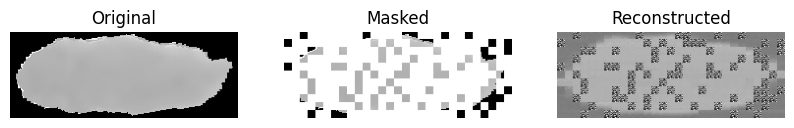

Epoch [96/100] Train Loss: 0.01556854


Epoch [96/100] Validation Loss: 0.01485458


Epoch [97/100] Train Loss: 0.01534952


Epoch [97/100] Validation Loss: 0.01565784


Epoch [98/100] Train Loss: 0.01533549


Epoch [98/100] Validation Loss: 0.01453298


Epoch [99/100] Train Loss: 0.01510000


Epoch [99/100] Validation Loss: 0.01502801


Epoch [100/100] Train Loss: 0.01512724


Epoch [100/100] Validation Loss: 0.01476906


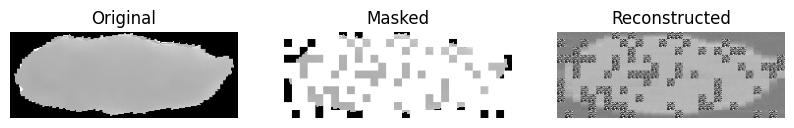

Training complete!


In [8]:

# Training loop
num_epochs = 100


for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    
    # Training loop with progress bar
    train_loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Train", leave=False)
    for images in train_loop:
        images = images.to(device)  # Move images to GPU
        
        optimizer.zero_grad()
        loss, _, _ = model(images)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        train_loop.set_postfix(loss=loss.item())
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_loss:.8f}")
    
    # Validation loop with progress bar
    model.eval()
    val_loss = 0.0
    val_loop = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Val", leave=False)
    with torch.no_grad():
        for images in val_loop:
            images = images.to(device)
            loss, _, _ = model(images)
            val_loss += loss.item()
            val_loop.set_postfix(loss=loss.item())
            
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Validation Loss: {avg_val_loss:.8f}")
    
    # plot each 5 epoch

    if (epoch+1) % 5 == 0:
        model.eval()
        with torch.no_grad():
            # select random batch
            images = next(iter(val_loader))
            images = images.to(device)

            _, pred, masks = model(images)

            # Split the images into patches
            patches, num_patches_h, num_patches_w = split_images(images, patch_size=8)

            masked_images = apply_mask_to_patches(images, patches, masks, patch_size = 8, num_patches_h = num_patches_h, num_patches_w = num_patches_w)

            # unpatch the pred
            recon_images = model.unpatchify(pred)

            visualize_image(images, masked_images, recon_images)
            

        
print("Training complete!")